#Making Predictions using Covid19 released Data
We use the official released data from WHO regarding the pandemic to make predictions. The used features are the Cumulative cases , deaths and new cases and deaths

In [1]:
import numpy as np 
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from operator import itemgetter, attrgetter
import os
from google.colab import drive
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from statistics import mean

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

In [3]:
drive.mount('/content/gdrive')
folderpath = '/content/gdrive/My Drive/Colab Notebooks/covidproject'
os.chdir(folderpath)

Mounted at /content/gdrive


In [4]:
import VisFunctions as vf

In [5]:
data = pd.read_csv('WHO-COVID-19-global-data2.csv')
population =  pd.read_excel('WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx', index_col=None, header=None)
population = np.array(population)

countries=data['Country'].unique()
Dates_reported=sorted(list(data['Date_reported'].unique()))
Population = vf.World_Population(population,countries)
countries_covid=[]
L=len(Dates_reported)
for i,c in enumerate(countries):
  country_object=vf.country(c)
  country_object.set_new_cases(data)
  country_object.set_new_deaths(data)
  country_object.set_cumulative_cases(data)
  country_object.set_cumulative_deaths(data)
  country_object.padding(L)
  country_object.set_total_cases()
  country_object.set_total_deaths()
  country_object.set_total_mr()
  country_object.set_daily_mr()
  country_object.set_cumulative_mr()
  country_object.set_population(Population)
  country_object.set_cases_per_million()
  country_object.set_deaths_per_million()
  countries_covid.append(country_object)

Wnew_cases,Wnew_deaths,Wcumulative_cases,Wcumulative_deaths,Wtotal_cases,Wtotal_deaths,Wcases_per_million,Wdeaths_per_million,mr,Wdaily_mr,Wcumulative_mr=vf.world_data(countries_covid)

#Prepare The Data for Neural Network Input
The dataset is devided into sequences (we choose of length 10) and at each sequence corresponds the value at the next time step as a label for a supervised learning problem.

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

    
class CustomDataset(Dataset):
  def __init__(self,x,y):
    self.X = x
    self.y = y
  
  def __len__(self):
      return len(self.X)
  
      
  def __getitem__(self,idx):
      return self.X[idx], self.y[idx]

In [7]:
#training_set = Wnew_cases
def split_dataset(training_set):
  #training_set = Wnew_cases
  sc = MinMaxScaler()
  training_data = sc.fit_transform(np.array(training_set).reshape(-1,1))

  seq_length = 10
  x, y = sliding_windows(training_data, seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))
  dataY = Variable(torch.Tensor(np.array(y)))
  train_size = int(len(y) * 0.90)
  test_size = len(y) - train_size
  train_dataset = CustomDataset(x[:train_size],y[:train_size])


  trainloader = DataLoader(train_dataset,batch_size = 64)
  test_datasetX =  Variable(torch.Tensor(np.array(x[train_size:])))
  test_datasety = Variable(torch.Tensor(np.array(y[train_size:])))
  return trainloader,dataX,dataY,sc,train_size

We use a very simple neural network architecture with one LSTM cell and a fully connected layer so we can map each sequence to one corresponding value.

In [8]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

We train the model using MSE loss and adam optimizer.

In [9]:
def train_model(model,trainloader,num_epochs,learning_rate):
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  losses_avg = []
  for epoch in range(num_epochs):
    losses = []
    for x,y in trainloader:
      x = x.float()
      y = y.float()
      y_hat = model(x)
      optimizer.zero_grad()
      loss = criterion(y_hat,y)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    losses_avg.append(mean(losses)) 
    if (epoch%100==0): print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
  return losses_avg

In [32]:
def plot_model_predictions(model,dataX,dataY,sc,train_size,title):
  model.eval()
  train_predict = model(dataX)

  data_predict = train_predict.data.numpy()
  dataY_plot = dataY.data.numpy()

  data_predict = sc.inverse_transform(data_predict)
  dataY_plot = sc.inverse_transform(dataY_plot)

  plt.figure(figsize=(8,8))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot)
  plt.plot(data_predict)
  plt.suptitle('Time-Series Forecasting')
  plt.xlabel('days passed')
  plt.ylabel(title)
  plt.show()

In [ ]:
trainloader,dataX,dataY,sc,train_size = split_dataset(Wnew_cases)


We define the model parameters. Input size and number of classes (output size) is 1 because we use only one feature per sample.

In [ ]:
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [ ]:
losses = train_model(model,trainloader,10000,0.001)

Epoch: 0, loss: 0.68246
Epoch: 100, loss: 0.00301
Epoch: 200, loss: 0.00122
Epoch: 300, loss: 0.00038
Epoch: 400, loss: 0.00038
Epoch: 500, loss: 0.00044
Epoch: 600, loss: 0.00048
Epoch: 700, loss: 0.00046
Epoch: 800, loss: 0.00049
Epoch: 900, loss: 0.00047
Epoch: 1000, loss: 0.00043
Epoch: 1100, loss: 0.00038
Epoch: 1200, loss: 0.00032
Epoch: 1300, loss: 0.00024
Epoch: 1400, loss: 0.00015
Epoch: 1500, loss: 0.00008
Epoch: 1600, loss: 0.00005
Epoch: 1700, loss: 0.00005
Epoch: 1800, loss: 0.00005
Epoch: 1900, loss: 0.00006
Epoch: 2000, loss: 0.00007
Epoch: 2100, loss: 0.00008
Epoch: 2200, loss: 0.00009
Epoch: 2300, loss: 0.00009
Epoch: 2400, loss: 0.00010
Epoch: 2500, loss: 0.00011
Epoch: 2600, loss: 0.00011
Epoch: 2700, loss: 0.00012
Epoch: 2800, loss: 0.00013
Epoch: 2900, loss: 0.00014
Epoch: 3000, loss: 0.00015
Epoch: 3100, loss: 0.00016
Epoch: 3200, loss: 0.00017
Epoch: 3300, loss: 0.00019
Epoch: 3400, loss: 0.00020
Epoch: 3500, loss: 0.00021
Epoch: 3600, loss: 0.00022
Epoch: 3700, 

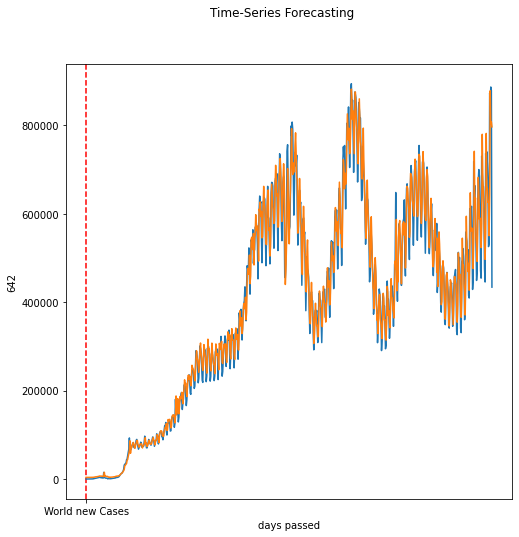

In [ ]:
plot_model_predictions(model,dataX,dataY,sc,train_size,'World new Cases')

  We can train the model to different time series. For example Greece.
  

In [14]:
def get_country(countries,country):
  for c in countries:
    if c.country_name == country: return c
 

In [21]:
country = get_country(countries_covid,'Greece')

In [36]:
trainloader,dataX,dataY,sc,train_size = split_dataset(country.new_cases)

input_size = 1
hidden_size = 10
num_layers = 1
num_classes = 1

model2 = LSTM(num_classes, input_size, hidden_size, num_layers)


losses = train_model(model2,trainloader,10000,0.001)

Epoch: 0, loss: 0.07901
Epoch: 100, loss: 0.00026
Epoch: 200, loss: 0.00029
Epoch: 300, loss: 0.00037
Epoch: 400, loss: 0.00087
Epoch: 500, loss: 0.00137
Epoch: 600, loss: 0.00089
Epoch: 700, loss: 0.00057
Epoch: 800, loss: 0.00054
Epoch: 900, loss: 0.00049
Epoch: 1000, loss: 0.00053
Epoch: 1100, loss: 0.00052
Epoch: 1200, loss: 0.00051
Epoch: 1300, loss: 0.00049
Epoch: 1400, loss: 0.00051
Epoch: 1500, loss: 0.00052
Epoch: 1600, loss: 0.00056
Epoch: 1700, loss: 0.00053
Epoch: 1800, loss: 0.00043
Epoch: 1900, loss: 0.00047
Epoch: 2000, loss: 0.00045
Epoch: 2100, loss: 0.00033
Epoch: 2200, loss: 0.00031
Epoch: 2300, loss: 0.00028
Epoch: 2400, loss: 0.00026
Epoch: 2500, loss: 0.00021
Epoch: 2600, loss: 0.00022
Epoch: 2700, loss: 0.00017
Epoch: 2800, loss: 0.00013
Epoch: 2900, loss: 0.00020
Epoch: 3000, loss: 0.00014
Epoch: 3100, loss: 0.00014
Epoch: 3200, loss: 0.00008
Epoch: 3300, loss: 0.00012
Epoch: 3400, loss: 0.00009
Epoch: 3500, loss: 0.00010
Epoch: 3600, loss: 0.00008
Epoch: 3700, 

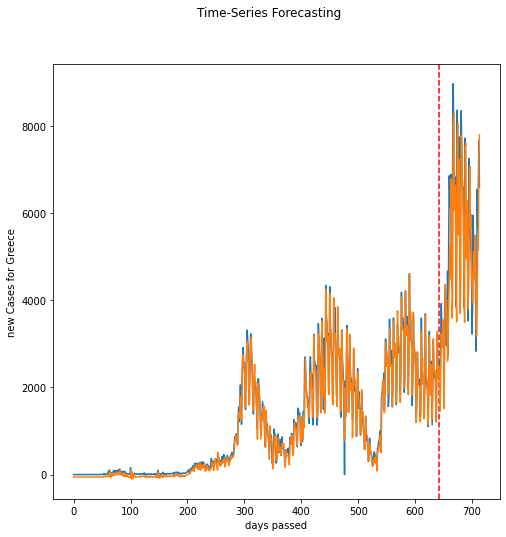

In [37]:
plot_model_predictions(model2,dataX,dataY,sc,train_size,'new Cases for '+country.country_name)

An other model can be also trained on the CUmulative Cases of Covid in Greece or similary with daily or cumulative deaths.

In [41]:
trainloader,dataX,dataY,sc,train_size = split_dataset(country.cumulative_cases)

input_size = 1
hidden_size = 10
num_layers = 1
num_classes = 1

model3 = LSTM(num_classes, input_size, hidden_size, num_layers)


losses = train_model(model3,trainloader,500,0.001)

Epoch: 0, loss: 0.17184
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00002
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00001


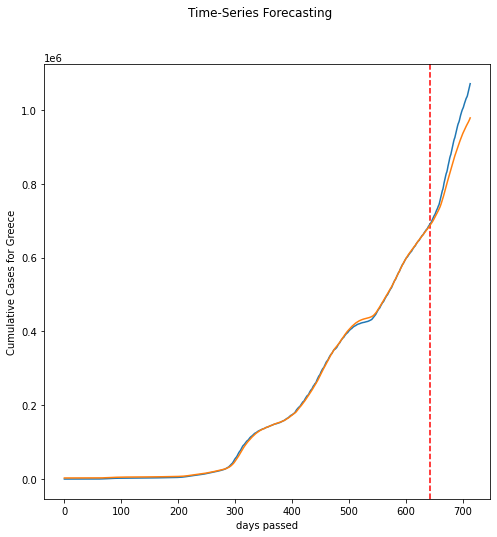

In [42]:
plot_model_predictions(model3,dataX,dataY,sc,train_size,'Cumulative Cases for '+country.country_name)

In [48]:
trainloader,dataX,dataY,sc,train_size = split_dataset(country.new_deaths)

input_size = 1
hidden_size = 10
num_layers = 1
num_classes = 1

model4 = LSTM(num_classes, input_size, hidden_size, num_layers)


losses = train_model(model4,trainloader,10000,0.001)

Epoch: 0, loss: 0.16040
Epoch: 100, loss: 0.00568
Epoch: 200, loss: 0.00496
Epoch: 300, loss: 0.00427
Epoch: 400, loss: 0.00355
Epoch: 500, loss: 0.00387
Epoch: 600, loss: 0.00408
Epoch: 700, loss: 0.00415
Epoch: 800, loss: 0.00384
Epoch: 900, loss: 0.00322
Epoch: 1000, loss: 0.00290
Epoch: 1100, loss: 0.00285
Epoch: 1200, loss: 0.00228
Epoch: 1300, loss: 0.00228
Epoch: 1400, loss: 0.00183
Epoch: 1500, loss: 0.00203
Epoch: 1600, loss: 0.00162
Epoch: 1700, loss: 0.00158
Epoch: 1800, loss: 0.00153
Epoch: 1900, loss: 0.00142
Epoch: 2000, loss: 0.00145
Epoch: 2100, loss: 0.00147
Epoch: 2200, loss: 0.00125
Epoch: 2300, loss: 0.00142
Epoch: 2400, loss: 0.00123
Epoch: 2500, loss: 0.00139
Epoch: 2600, loss: 0.00105
Epoch: 2700, loss: 0.00095
Epoch: 2800, loss: 0.00095
Epoch: 2900, loss: 0.00075
Epoch: 3000, loss: 0.00081
Epoch: 3100, loss: 0.00066
Epoch: 3200, loss: 0.00062
Epoch: 3300, loss: 0.00114
Epoch: 3400, loss: 0.00057
Epoch: 3500, loss: 0.00042
Epoch: 3600, loss: 0.00038
Epoch: 3700, 

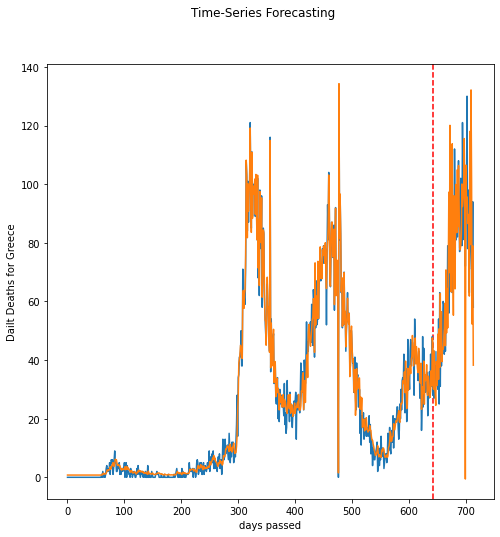

In [49]:
plot_model_predictions(model4,dataX,dataY,sc,train_size,'Dailt Deaths for '+country.country_name)

In [52]:
trainloader,dataX,dataY,sc,train_size = split_dataset(country.cumulative_deaths)

input_size = 1
hidden_size = 10
num_layers = 1
num_classes = 1

model5 = LSTM(num_classes, input_size, hidden_size, num_layers)


losses = train_model(model5,trainloader,500,0.001)

Epoch: 0, loss: 0.14588
Epoch: 100, loss: 0.00017
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00006
Epoch: 400, loss: 0.00004


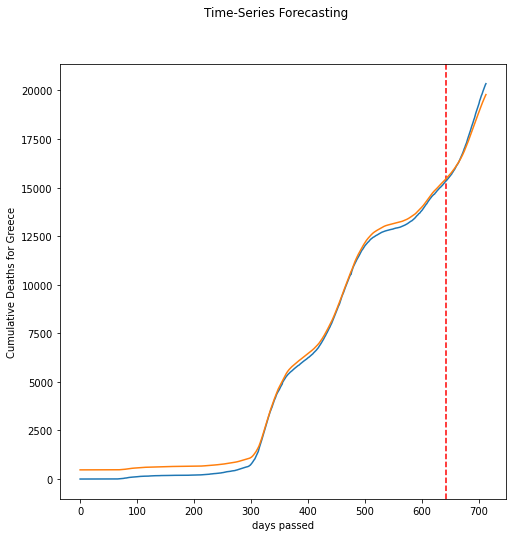

In [53]:
plot_model_predictions(model5,dataX,dataY,sc,train_size,'Cumulative Deaths for '+country.country_name)

Further implementations: Use samples with multiple features eg cases , deaths for each day and train models with input size of 2.